**Create a Spark session**

In [33]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HealthcareAnalysis").getOrCreate()

**Check Spark version**

In [34]:
print("Apache Spark version:", spark.version)

Apache Spark version: 3.5.5


**Load Your Dataset**

In [35]:
df = spark.read.csv("/content/healthcare_dataset.csv", header=True, inferSchema=True)
df.show(5)


+-------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|         Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|            Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+-------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|Bobby JacksOn| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|     Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|
| LesLie TErRy| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|             Kim Inc|          Medicare|33

**Explore the Data**

In [36]:
df.printSchema()


root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



In [37]:
print("Total Rows:", df.count())


Total Rows: 55500


In [38]:
df.show(10)


+------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|              Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|            Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|     Bobby JacksOn| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|     Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|
|      LesLie TErRy| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|             Kim 

**check for missing values**

In [39]:
from pyspark.sql.functions import col, sum
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+
|Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|Doctor|Hospital|Insurance Provider|Billing Amount|Room Number|Admission Type|Discharge Date|Medication|Test Results|
+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+
|   0|  0|     0|         0|                0|                0|     0|       0|                 0|             0|          0|             0|             0|         0|           0|
+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+



**Basic Statistics**

In [40]:
df.describe().show()

+-------+------------+------------------+------+----------+-----------------+-------------+--------------------+------------------+-------------------+-----------------+--------------+----------+------------+
|summary|        Name|               Age|Gender|Blood Type|Medical Condition|       Doctor|            Hospital|Insurance Provider|     Billing Amount|      Room Number|Admission Type|Medication|Test Results|
+-------+------------+------------------+------+----------+-----------------+-------------+--------------------+------------------+-------------------+-----------------+--------------+----------+------------+
|  count|       55500|             55500| 55500|     55500|            55500|        55500|               55500|             55500|              55500|            55500|         55500|     55500|       55500|
|   mean|        NULL| 51.53945945945946|  NULL|      NULL|             NULL|         NULL|                NULL|              NULL| 25539.316097211744|301.134828828

**Most Common Medical Conditions**

In [42]:
df.groupBy("Medical Condition").count().orderBy(col("count").desc()).show(10, False)


+-----------------+-----+
|Medical Condition|count|
+-----------------+-----+
|Arthritis        |9308 |
|Diabetes         |9304 |
|Hypertension     |9245 |
|Obesity          |9231 |
|Cancer           |9227 |
|Asthma           |9185 |
+-----------------+-----+



**Average Billing Amount by Insurance Provider**

In [43]:
df.groupBy("Insurance Provider").avg("Billing Amount").orderBy(col("avg(Billing Amount)").desc()).show(10, False)


+------------------+-------------------+
|Insurance Provider|avg(Billing Amount)|
+------------------+-------------------+
|Medicare          |25615.990507988434 |
|Blue Cross        |25613.011503051068 |
|Aetna             |25553.294506111477 |
|Cigna             |25525.76631422353  |
|UnitedHealthcare  |25389.172390383454 |
+------------------+-------------------+



**Admission Type Distribution**

In [44]:
df.groupBy("Admission Type").count().orderBy(col("count").desc()).show()


+--------------+-----+
|Admission Type|count|
+--------------+-----+
|      Elective|18655|
|        Urgent|18576|
|     Emergency|18269|
+--------------+-----+



**Most Common Admission Month**

In [45]:
from pyspark.sql.functions import month

df = df.withColumn("Admission Month", month("Date of Admission"))

df.groupBy("Admission Month").count().orderBy(col("count").desc()).show()


+---------------+-----+
|Admission Month|count|
+---------------+-----+
|              8| 4832|
|              7| 4812|
|              6| 4699|
|              1| 4692|
|             10| 4678|
|              3| 4672|
|             12| 4649|
|              5| 4599|
|             11| 4548|
|              9| 4546|
|              4| 4518|
|              2| 4255|
+---------------+-----+



**Length of Stay in Hospital**

In [46]:
from pyspark.sql.functions import datediff

df = df.withColumn("Length of Stay", datediff("Discharge Date", "Date of Admission"))

df.select("Name", "Medical Condition", "Length of Stay").show(10, False)


+------------------+-----------------+--------------+
|Name              |Medical Condition|Length of Stay|
+------------------+-----------------+--------------+
|Bobby JacksOn     |Cancer           |2             |
|LesLie TErRy      |Obesity          |6             |
|DaNnY sMitH       |Obesity          |15            |
|andrEw waTtS      |Diabetes         |30            |
|adrIENNE bEll     |Cancer           |20            |
|EMILY JOHNSOn     |Asthma           |4             |
|edwArD EDWaRDs    |Diabetes         |12            |
|CHrisTInA MARtinez|Cancer           |10            |
|JASmINe aGuIlaR   |Asthma           |13            |
|ChRISTopher BerG  |Cancer           |30            |
+------------------+-----------------+--------------+
only showing top 10 rows



**Top 10 Patients with the Highest Billing Amount**

In [47]:
df=df.dropDuplicates(["Name", "Billing Amount"])
df.select("Name", "Billing Amount").orderBy(col("Billing Amount").desc()).show(10, False)


+-----------------+------------------+
|Name             |Billing Amount    |
+-----------------+------------------+
|tOdd CARrILlO    |52764.276736469175|
|kARen klInE      |52373.032374241826|
|DAVId SanDOvaL   |52271.66374715383 |
|kathRYN GoNzales |52211.85296638021 |
|BRETT mARshAll   |52181.837792399056|
|LAuRie hOod      |52170.03685355641 |
|JUstIn CLark     |52154.237721878235|
|sCotT pOWElL     |52102.24088919256 |
|CAmEroN HeRnAndez|52092.669895844054|
|TOm smItH        |52024.72644288463 |
+-----------------+------------------+
only showing top 10 rows



**Average Billing by Admission Type**

In [50]:
df.groupBy("Admission Type").avg("Billing Amount").orderBy(col("avg(Billing Amount)").desc()).show()


+--------------+-------------------+
|Admission Type|avg(Billing Amount)|
+--------------+-------------------+
|      Elective| 25618.775711653685|
|     Emergency| 25528.467891811233|
|        Urgent|  25519.02875701066|
+--------------+-------------------+



**Data Visualization**

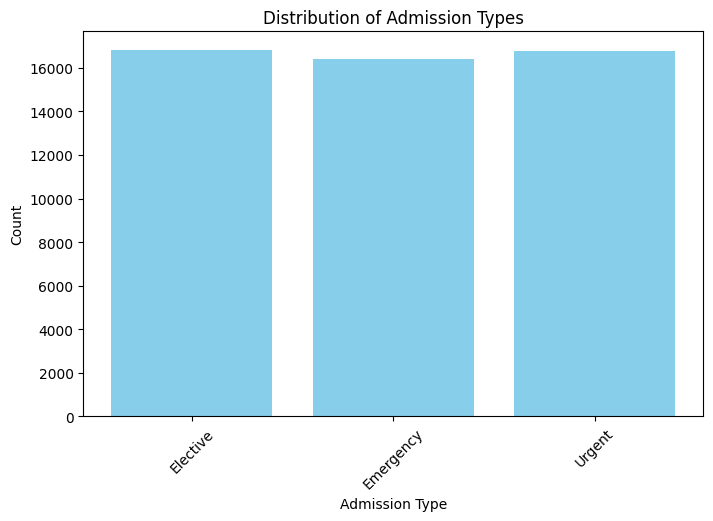

In [49]:
import matplotlib.pyplot as plt

# Convert to Pandas
df_pandas = df.groupBy("Admission Type").count().toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(df_pandas["Admission Type"], df_pandas["count"], color='skyblue')
plt.xlabel("Admission Type")
plt.ylabel("Count")
plt.title("Distribution of Admission Types")
plt.xticks(rotation=45)
plt.show()


### Big Data Analysis - Healthcare Dataset (PySpark)

#### Key Insights:
- The most common medical condition is **Arthritis**.
- The highest number of admissions occurred in **August Month**.
- Patients with **Medicare  Insurance Provider**  have the highest billing amount.
-  Elective admissions tend to be **more expensive** than elective ones.
- Elective admissions are the most frequent type of admission, followed closely by Urgent and then Emergency admissions.
- **tOdd CARrILlO and kARen klInE** have the highest billing amounts.
